# ¿Qué importancia tiene la fuente de ingresos del solicitante de un préstamo online?

## Objetivos

Al final de este caso, estará familiarizado con la regresión logística. En concreto, aprenderá a realizar e interpretar los coeficientes de un modelo de regresión logística para obtener información sobre su problema.

Durante el estudio del caso, se le presentará la regresión logística como medio para probar una hipótesis. A continuación, validará esta hipótesis convirtiendo la regresión logística en un clasificador y midiendo su rendimiento. La comprensión de la teoría y la interpretación de la regresión logística es una herramienta vital en el ámbito de la ciencia de datos, especialmente en la clasificación.

## Introducción

**Contexto empresarial.** Los préstamos en línea entre iguales (P2P) han facilitado la práctica de los préstamos. En esta forma de préstamo, no hay entrevista en persona y un prestatario puede simplemente rellenar un formulario en línea y obtener la aprobación de un préstamo. La información proporcionada únicamente por el prestatario es propensa a la exageración y la distorsión, especialmente cuando se trata de los ingresos. Todas las empresas de préstamos P2P se basan en un procedimiento bien diseñado que rechaza a los prestatarios con una alta probabilidad de no pagar sus deudas.

Rechazar a cualquiera que no tenga una fuente de ingresos verificada es una política relevante que las plataformas de préstamo pueden poner en marcha para ayudar a reducir la tasa de préstamos fallidos. Es natural sospechar que si no se puede verificar la fuente de ingresos de una persona, ésta podría no pagar el préstamo. Sin embargo, desde el punto de vista del prestatario, el proceso de verificación puede ser engorroso y llevar mucho tiempo, por lo que es posible que se cambie a otra plataforma debido a este inconveniente. 

**Problema empresarial.** Como científico de datos en una empresa emergente de préstamos P2P, debe responder a la siguiente pregunta: **"¿Debe la empresa verificar la fuente de ingresos de un solicitante de préstamo online antes de aprobar su préstamo? "**

**Contexto analítico.**  Los datos se han descargado de [LendingClub (LC) Statistics] (https://www.lendingclub.com/info/download-data.action) y contienen todos los préstamos emitidos entre 2007 y 2012 junto con su estado actual (totalmente pagados o cancelados). Hay ~50 variables que describen a los prestatarios y los préstamos; en aras de reducir la complejidad, la empresa ya ha realizado una preselección de estas variables basándose en los análisis existentes de LendingClub para seleccionar nueve variables relevantes, como los ingresos anuales, el grado de crédito de LendingClub, la propiedad de la vivienda, etc. Utilizaremos una nueva técnica, la **regresión logística**, para responder a nuestra pregunta.

El caso está estructurado de la siguiente manera:
 1. explorar los datos existentes para tener una idea aproximada de cómo interactúa cada variable del conjunto de datos con el estado actual del préstamo
 2. buscar los posibles efectos de confusión
 3. aprender los fundamentos de los modelos de regresión logística y, por último
 4. ajustar una serie de modelos de regresión logística para determinar si la verificación de la fuente de ingresos es o no significativa.

In [1]:
# Load packages

import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as sfm

from matplotlib.widgets import Slider, Button, RadioButtons
from scipy import interp
from scipy.optimize import fsolve
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from statsmodels.formula.api import ols


from IPython.display import display_html

## Exploración de datos

Antes de comenzar nuestro análisis exploratorio, echemos un vistazo a los datos que tenemos a nuestra disposición:

In [4]:
#Load the data
df = pd.read_csv('Lending_club_cleaned_2.csv')

#Change loan_status, verification_status, emp_length, term and grade to category type 
df.loan_status = df.loan_status.astype(pd.api.types.CategoricalDtype(categories=['Charged Off', 'Fully Paid']))
df.verification_status = df.verification_status.astype(pd.api.types.CategoricalDtype(categories=['Not Verified', 'Source Verified', 'Verified']))
df.emp_length = df.emp_length.astype(pd.api.types.CategoricalDtype(categories=['< 1 year', '1 year', '2 years', '3 years', '4 years', \
                                                             '5 years', '6 years', '7 years', '8 years', '9 years', \
                                                             '10+ years']))
df.home_ownership = df.home_ownership.astype(pd.api.types.CategoricalDtype(categories=['RENT','MORTGAGE','OWN','OTHER']))
df.term = df.term.astype(pd.api.types.CategoricalDtype(categories=[' 36 months', ' 60 months']))
df.grade = df.grade.astype(pd.api.types.CategoricalDtype(categories=['A','B','C','D','E','F','G']))

#In addition, the original data in int_rate contains strings of the form 'x.xx%',
#we remove the % and change the vaules to float:
df.int_rate = df.int_rate.str.rstrip('%').astype('float')

In [5]:
df.shape

(38705, 10)

In [6]:
df.head(10)

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65,5000,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27,2500,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96,2400,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49,10000,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69,3000,other,60 months,B
5,Fully Paid,36000.0,Source Verified,3 years,RENT,7.90,5000,wedding,36 months,A
6,Fully Paid,47004.0,Not Verified,8 years,RENT,15.96,7000,debt_consolidation,60 months,C
7,Fully Paid,48000.0,Source Verified,9 years,RENT,18.64,3000,car,36 months,E
8,Charged Off,40000.0,Source Verified,4 years,OWN,21.28,5600,small_business,60 months,F
9,Charged Off,15000.0,Verified,< 1 year,RENT,12.69,5375,other,60 months,B


Tenemos 38705 registros de transacciones pasadas en este conjunto de datos. Cada registro corresponde a un préstamo aprobado. La primera columna indica si el prestatario pagó el préstamo (totalmente pagado) o no (cargado). Las descripciones de las otras nueve columnas son las siguientes:

|      annual_inc     |                                                 The self-reported annual income provided by the borrower during registration.                                                |
|:-------------------:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| verification_status |                                          Indicates if income was verified by LC, not verified, or if the income source was verified                                          |
|      emp_length     |                       Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.                      |
|    home_ownership   |             The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER            |
|       int_rate      |                                                                           Interest Rate on the loan                                                                          |
|      loan_amnt      | The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value. |
|       purpose       |                                                           A category provided by the borrower for the loan request.                                                          |
|         term        |                                             The number of payments on the loan. Values are in months and can be either 36 or 60.                                             |
|        grade        |                                                                            LC assigned loan grade                                                                            |

### Relaciones entre `loan_status` y otras variables

En primer lugar, realizamos un EDA para examinar la relación por pares entre "estado del préstamo" y cada una de las demás variables. En el conjunto de datos tenemos variables discretas y continuas. Empecemos a explorar las variables `anual_inc`, `int_rate` y `loan_amnt` en los usuarios que pagaron totalmente sus deudas frente a los que no lo hicieron:

<AxesSubplot:xlabel='loan_status', ylabel='loan_amnt'>

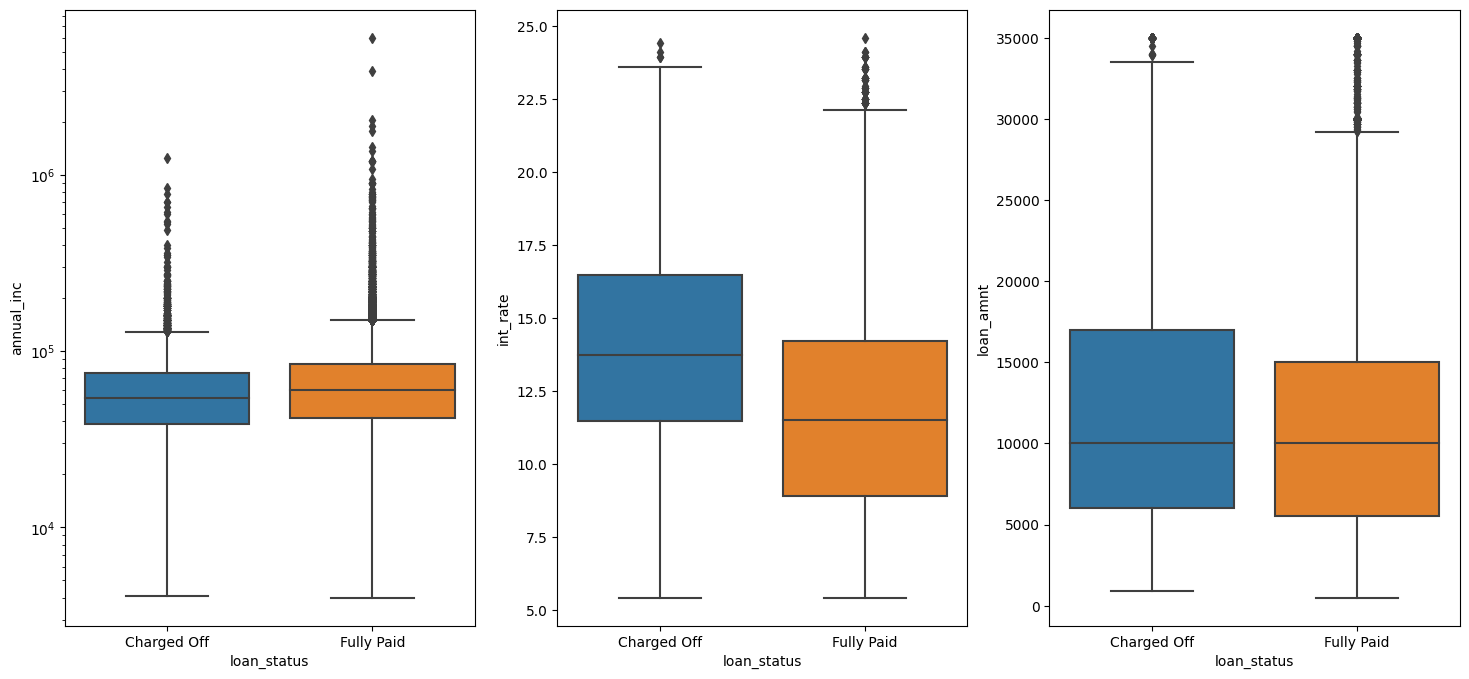

In [7]:
fig, ax=plt.subplots(1,3, figsize=(18,8))
sns.boxplot(y='annual_inc', x='loan_status', data=df, ax=ax[0]).set_yscale('log')
sns.boxplot(y='int_rate', x ='loan_status', data = df, ax=ax[1])
sns.boxplot(y='loan_amnt', x='loan_status', data=df, ax=ax[2])

### Ejercicio 1:

#### 1.1

¿Qué observas en los gráficos de caja anteriores? 

#### 1.2

Considere la afirmación:

> "A partir de estos gráficos podemos concluir que los ingresos anuales no desempeñan un papel significativo a la hora de decidir si un usuario va a devolver o no su préstamo."

¿Cree que esta afirmación es correcta? ¿Cómo intentarías comprobarlo? 

In [11]:
a=df[df['loan_status']=="Charged Off"]['annual_inc']
b=df[df['loan_status']=="Fully Paid"]['annual_inc']
T,p=ttest_ind(a,b)
p

1.9075011302588803e-14

Podemos utilizar tablas de contingencia para examinar la relación entre dos variables discretas. Se puede realizar una prueba de chi-cuadrado basada en la tabla de contingencia para verificar si la relación observada es estadísticamente significativa. La siguiente función genera la tabla de contingencia entre `estado_de_préstamo` y otra variable dada llamada `var`:

In [12]:
def get_ct(df, var):
    ct_res = pd.crosstab(df[var], df['loan_status'], margins=True)
    ct_res['Fully Paid(%)'] = round( ct_res['Fully Paid']/ct_res['All']*100, 2)
    return ct_res.drop(columns='All')

Por ejemplo, calculemos la tabla de contingencia de `estado_de_préstamo` frente a `estado_de_verificación`:

In [13]:
get_ct(df, 'verification_status')

loan_status,Charged Off,Fully Paid,Fully Paid(%)
verification_status,,,
Not Verified,2050,14449,87.58
Source Verified,1413,8406,85.61
Verified,1977,10410,84.04
All,5440,33265,85.94


### Ejercicio 2:



#### 2.1

¿Qué se desprende del cuadro anterior? ¿Podemos concluir que la verificación de la fuente de ingresos no es necesaria para nuestro cliente?

**Answer.** One possible solution is shown below:

From the table, `verification_status` seems to have a counter-intuitive association with `loan_status` - the less reliable the income information is, the more likely a user would fully repay the debt, as reflected by the decreasing trend of fully paid proportions when `verification_status increases` trends from not verified to fully verified. At first glance, this indicates that source verification may be a waste of money for the client. However, we must be careful with our conclusions as this table is not taking into account other possible factors that may have an effect on users paying off their debts. For instance, it may be the case that a considerable portion of loans with smaller interest rates were given to non-verified users, which made it easier to pay off the loan.

#### 2.2

Utilice una prueba de chi-cuadrado para verificar si las asociaciones observadas entre "estado de verificación" y "estado de préstamo" son estadísticamente significativas.

**Sugerencia:** Utilice `chi2, p, dof, ex=chi2_contingency(pd.crosstab(index=x,columns=y))` para realizar una prueba de chi-cuadrado para un par de datos dado `x, y`.

**Una posible solución se muestra a continuación:

In [14]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(index=df['verification_status'], columns=df['loan_status']))
print('verification_status: p-value of chisquare test =', p)

verification_status: p-value of chisquare test = 6.884998281535999e-17


La prueba de chi-cuadrado verifica que las asociaciones entre "estado de verificación" y "estado de préstamo" son realmente significativas desde el punto de vista estadístico.

#### 2.3

Considere las siguientes afirmaciones:

> I. "Dado que la prueba de chi-cuadrado para la tabla de contingencia de `estado_de_verificación` frente a `estado_de_préstamo` es significativa, la tendencia decreciente de la probabilidad de pago no es probable que se deba al azar".

> II. "Dado que existe una diferencia significativa entre la probabilidad de pago total en los usuarios sin ingresos verificados y los usuarios con ingresos verificados según la prueba de chi-cuadrado, deberíamos aplicar siempre la verificación de ingresos."

¿Son correctas las afirmaciones?

**Answer.** One possible solution is shown below:

Statement I is not correct. The chi-sqaure test is not a trend test, it only suggests that there is significant difference in the probability of pay-off among the three levels of `verification_status`, but it cannot further verify that the differences form a specific trend.

Statement II is not correct since it implies a causal relationship between `verification_status` and `loan_status`. There is not enough evidence to deduce this, and we should first assess if there are potential confounding variables like we did in previous cases before making such a strong conclusion.

### Tablas de contigencia estratificadas de `estado_de_verificación` frente a `estado_de_préstamo`

Como vimos en el ejercicio anterior, tenemos que ajustar por otras variables para eliminar posibles impactos de confusión. Si queremos saber si el `estado de la verificación` está realmente asociado con el `estado del préstamo` como indica la tabla de contigencia anterior, debemos considerar la estratificación de la tabla de contingencia entre el `estado del préstamo` y el `estado de la verificación` por otras variables que también están asociadas con el `estado del préstamo`.

### Ejercicio 3:

Escriba una función que genere una tabla de contingencia para `estado de verificación` frente a `estado de préstamo` estratificada por la `stra_var`, el argumento de la función. Asegúrese de incluir una columna para la proporción de usuarios totalmente pagados en cada nivel de "estado de verificación". Utilice esta función para examinar la relación entre el "estado de verificación" y el "estado de los préstamos" cuando se ajuste por la "propiedad de la vivienda" y el "plazo". ¿Seguimos viendo la misma tendencia a través de los diferentes niveles de "propiedad de la vivienda" y "plazo"?

**Sugerencia:** Cuando se utiliza el parámetro `index` de `pd.crosstab()` con dos variables, la tabla de contingencia se estratifica por la primera variable en `index`.

**Una posible solución se muestra a continuación:

In [15]:
def get_ct_stra(stra_var):
    ct_stra = pd.crosstab(index=[stra_var,df.verification_status], columns = df.loan_status, margins = True)
    ct_stra['Fully Paid (%)'] = round(ct_stra['Fully Paid']/ct_stra['All']*100,2)
    return ct_stra.drop(columns='All').drop('All', level=0)

In [16]:
get_ct_stra(df.home_ownership)

loan_status                         Charged Off  Fully Paid  Fully Paid (%)
home_ownership verification_status                                         
RENT           Not Verified                1072        7133           86.93
               Source Verified              815        4332           84.17
               Verified                     865        4290           83.22
MORTGAGE       Not Verified                 798        6064           88.37
               Source Verified              487        3443           87.61
               Verified                     983        5480           84.79
OWN            Not Verified                 170        1210           87.68
               Source Verified              110         622           84.97
               Verified                     122         611           83.36
OTHER          Not Verified                  10          42           80.77
               Source Verified                1           9           90.00
               Verified                       7          29           80.56

In [17]:
get_ct_stra(df.term)

loan_status                     Charged Off  Fully Paid  Fully Paid (%)
term       verification_status                                         
 36 months Not Verified                1580       12574           88.84
           Source Verified              688        6132           89.91
           Verified                     805        6505           88.99
 60 months Not Verified                 470        1875           79.96
           Source Verified              725        2274           75.83
           Verified                    1172        3905           76.92

Podemos ver que la tendencia se mantiene cuando se estratifica por "propiedad del hogar". La proporción de usuarios de pago completo disminuye a medida que el estado de verificación es menos fiable, independientemente de los niveles de "propiedad de la vivienda". La excepción es el nivel "OTRO". Pero como tenemos muy pocos usuarios allí, no deberíamos confiar demasiado en los resultados. La tendencia ya no se mantiene en ambos niveles de "plazo". Podemos ver que la proporción de usuarios totalmente pagados con un plazo de préstamo más corto (36 meses) sigue siendo la misma en los distintos niveles de "estado de verificación", en torno al 88%.

### Ejercicio 4:

Comparando las tablas de contingencia estratificadas con las homólogas no estratificadas, ¿cuál de las siguientes conclusiones es correcta? Seleccione todas las que correspondan.

I. Basándose en la tabla de contigencia estratificada, la diferencia en la probabilidad de pago completo entre los usuarios con y sin verificación de ingresos podría ser atribuible al efecto del plazo del préstamo en la probabilidad de pago completo.

II. Basándose en la tabla de contigencia estratificada, la diferencia en la probabilidad de pago completo entre los usuarios con y sin verificación de ingresos no es probablemente atribuible al efecto de la propiedad de la vivienda en la probabilidad de pago completo.

III. Supongamos que los usuarios sin ingresos verificados son más propensos a pedir préstamos a corto plazo en comparación con los usuarios con ingresos verificados y que los usuarios con préstamos a corto plazo son más propensos a pagar sus deudas. Si, de hecho, el estado de verificación de los ingresos no tiene ningún efecto sobre la probabilidad de devolver la deuda, los usuarios sin ingresos verificados siguen teniendo, al margen, más probabilidades de pagar su deuda.

## Extracción de información adicional con regresión lineal

A partir de la prueba de chi-cuadrado, sabemos que el estado de verificación está marginalmente asociado a la probabilidad de pago. Observamos en la tabla de contingencia que esta probabilidad aumenta cuando la información sobre los ingresos es menos fiable. Sin embargo, esta observación no puede verificarse sólo con la prueba estándar de chi-cuadrado.
    
Como primera aproximación, vamos a crear un modelo lineal que pretende explicar `estado_de_préstamo` utilizando las variables dadas en nuestro conjunto de datos. Tenga en cuenta que "estado_de_préstamo" es una variable categórica, por lo que es necesario dummificarla primero. Además, dado que las variables "estado_de_verificación", "grado" y "término" son ordinales, podríamos utilizar también sus códigos categóricos (esto supondría que los saltos en las categorías son iguales, lo que podría ser razonable para algunas de estas variables). Por último, para evitar que aparezcan números grandes en los coeficientes de la regresión, vamos a normalizar los datos numéricos. Este procedimiento no afecta al resultado de la regresión - OLS es invariante bajo transformaciones lineales:

In [19]:
df2=df.copy()

var_names=['loan_status','verification_status','grade','term']
for var in var_names:
    df2[var]=df2[var].cat.codes
    
var_names2=['annual_inc','int_rate','loan_amnt']
for var in var_names2:
    df2[var]=(df2[var]-df2[var].mean())/df2[var].std()

Consideremos un modelo sencillo con las variables `annual_inc`, `verification_status`, `loan_amnt`, `int_rate` y `term`:

In [20]:
model1 = 'loan_status~verification_status+annual_inc+loan_amnt+int_rate+term'
lm1   = sfm.ols(formula = model1, data = df2).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_status   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     385.5
Date:                Thu, 15 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:36:47   Log-Likelihood:                -13075.
No. Observations:               38705   AIC:                         2.616e+04
Df Residuals:                   38699   BIC:                         2.621e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.8763    

### Ejercicio 5:



#### 5.1

¿Qué puedes concluir de estos resultados?

#### 5.2

¿Qué desventajas crees que tiene un regresor lineal en esta situación?